In [1]:
import openmm
from openff.interchange import Interchange
from openff.toolkit import get_available_force_fields
from openff.units.openmm import from_openmm
from rdkit.Chem import rdMolAlign, rdMolDescriptors
from rdkit.Chem import AllChem as Chem

from collections import OrderedDict

from openff.toolkit import ForceField, Molecule

In [2]:
test_mol = Chem.MolFromSmiles(
    "CC(C)[C@@H](C=[16O])[C@H](C[N+](=O)[O-])/C=C/C1=CC=C(C=C1)OC"
)
test_mol.SetProp("_Name", rdMolDescriptors.CalcMolFormula(test_mol))

In [3]:
test_mol.GetNumConformers()

0

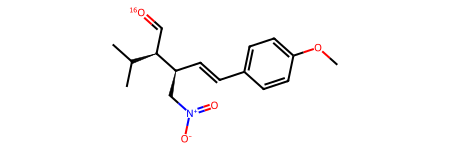

In [4]:
test_mol

In [5]:
test_mol = Chem.AddHs(test_mol, addCoords=True)

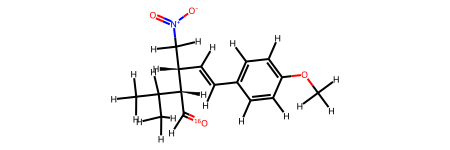

In [6]:
test_mol

In [7]:
props = Chem.MMFFGetMoleculeProperties(test_mol, mmffVariant="MMFF94s")

In [8]:
%%time
confIds = Chem.EmbedMultipleConfs(
    test_mol,
    numConfs=6000,
    pruneRmsThresh=0.3,
    forceTol=0.01,
    enforceChirality=True,
    useExpTorsionAnglePrefs=True,
    useBasicKnowledge=True,
    numThreads=16,
)

CPU times: user 2min 15s, sys: 51.9 ms, total: 2min 15s
Wall time: 27.7 s


In [9]:
test_mol.GetNumConformers()

1645

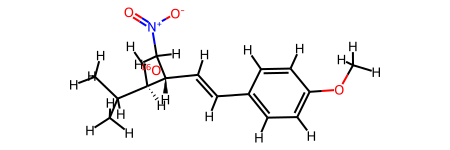

In [10]:
Chem.Mol(test_mol, confId=8)

In [11]:
openff_mol = Chem.Mol(test_mol)

In [12]:
sim_mol = Molecule.from_rdkit(
    test_mol, hydrogens_are_explicit=True, allow_undefined_stereo=False
)

In [13]:
sim_top = sim_mol.to_topology()

In [14]:
# ff_name = "openff_unconstrained-2.2.0.offxml"
ff_name = "openff-2.0.0.offxml"

ff_list = get_available_force_fields()
if ff_name in ff_list:
    sim_ff = ForceField(ff_name, load_plugins=True)

/home/tferreira/.cache/pypoetry/virtualenvs/stickit-JxL7hOEK-py3.11/lib/python3.11/site-packages/smirnoff99frosst/smirnoff99frosst.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [15]:
# for ff_name in get_available_force_fields():
#     sim_ff = ForceField(ff_name, load_plugins=True)
#     try:
#         interchange = Interchange.from_smirnoff(sim_ff, [sim_mol])
#         print(f"{ff_name}: SUCCESS")
#     except:
#         pass
#         # print(f"{ff_name}: FAILED")

In [16]:
%%time
interchange = Interchange.from_smirnoff(sim_ff, sim_top)

CPU times: user 2.56 s, sys: 19 ms, total: 2.58 s
Wall time: 42.2 s


In [17]:
integrator = openmm.VerletIntegrator(1 * openmm.unit.femtoseconds)
simulation = interchange.to_openmm_simulation(integrator)

In [18]:
%%time
# We'll store energies in two lists
initial_energies = []
minimized_energies = []

# And minimized conformers in a second molecule
minimized_molecule = Molecule(sim_mol)
minimized_molecule.conformers.clear()

gradient = 0.001 * openmm.unit.kilocalorie_per_mole / openmm.unit.angstrom
iterations = 2000

kJ_per_mol_nm = openmm.unit.kilojoules_per_mole / openmm.unit.nanometer
for conformer in sim_mol.conformers:
    # Tell the OpenMM Simulation the positions of this conformer
    simulation.context.setPositions(conformer.to_openmm())

    # Keep a record of the initial energy
    initial_energies.append(
        simulation.context.getState(getEnergy=True).getPotentialEnergy()
    )

    # Perform the minimization
    simulation.minimizeEnergy(
        tolerance=gradient.in_units_of(kJ_per_mol_nm), maxIterations=iterations
    )

    # Record minimized energy and positions
    min_state = simulation.context.getState(getEnergy=True, getPositions=True)

    minimized_energies.append(min_state.getPotentialEnergy())
    minimized_molecule.add_conformer(from_openmm(min_state.getPositions()))

result_mol = minimized_molecule.to_rdkit()

CPU times: user 12min 8s, sys: 1h 19min 4s, total: 1h 31min 12s
Wall time: 8min 15s


In [19]:
rdMolAlign.AlignMolConformers(result_mol)

In [20]:
# Get a shortcut to the number of conformers
n_confs = minimized_molecule.n_conformers
print(f"{minimized_molecule.name}: {n_confs} conformers")

# Create a copy of the molecule so we can work on it
working_mol = Molecule(minimized_molecule)

# Text header
output = [
    [
        "Conformer",
        "Initial PE (kcal/mol)",
        "Minimized PE (kcal/mol)",
        "RMSD of minimized structure (Å)",
    ]
]

for i, (init_energy, init_coords, min_energy, min_coords) in enumerate(
    zip(
        initial_energies,
        sim_mol.conformers,
        minimized_energies,
        minimized_molecule.conformers,
    )
):
    # Clear the conformers from the working molecule
    working_mol.conformers.clear()

    working_mol.add_conformer(min_coords)

    # Calculate the RMSD between the initial and minimized conformer
    working_mol.add_conformer(init_coords)
    rdmol = working_mol.to_rdkit()
    rmslist = []
    rdMolAlign.AlignMolConformers(rdmol, RMSlist=rmslist)
    minimization_rms = rmslist[0]

    # Record the results
    output.append(
        [
            i + 1,
            init_energy.value_in_unit(openmm.unit.kilocalories_per_mole),
            min_energy.value_in_unit(openmm.unit.kilocalories_per_mole),
            minimization_rms,
        ]
    )

C16H21NO4: 1645 conformers


/home/tferreira/.cache/pypoetry/virtualenvs/stickit-JxL7hOEK-py3.11/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


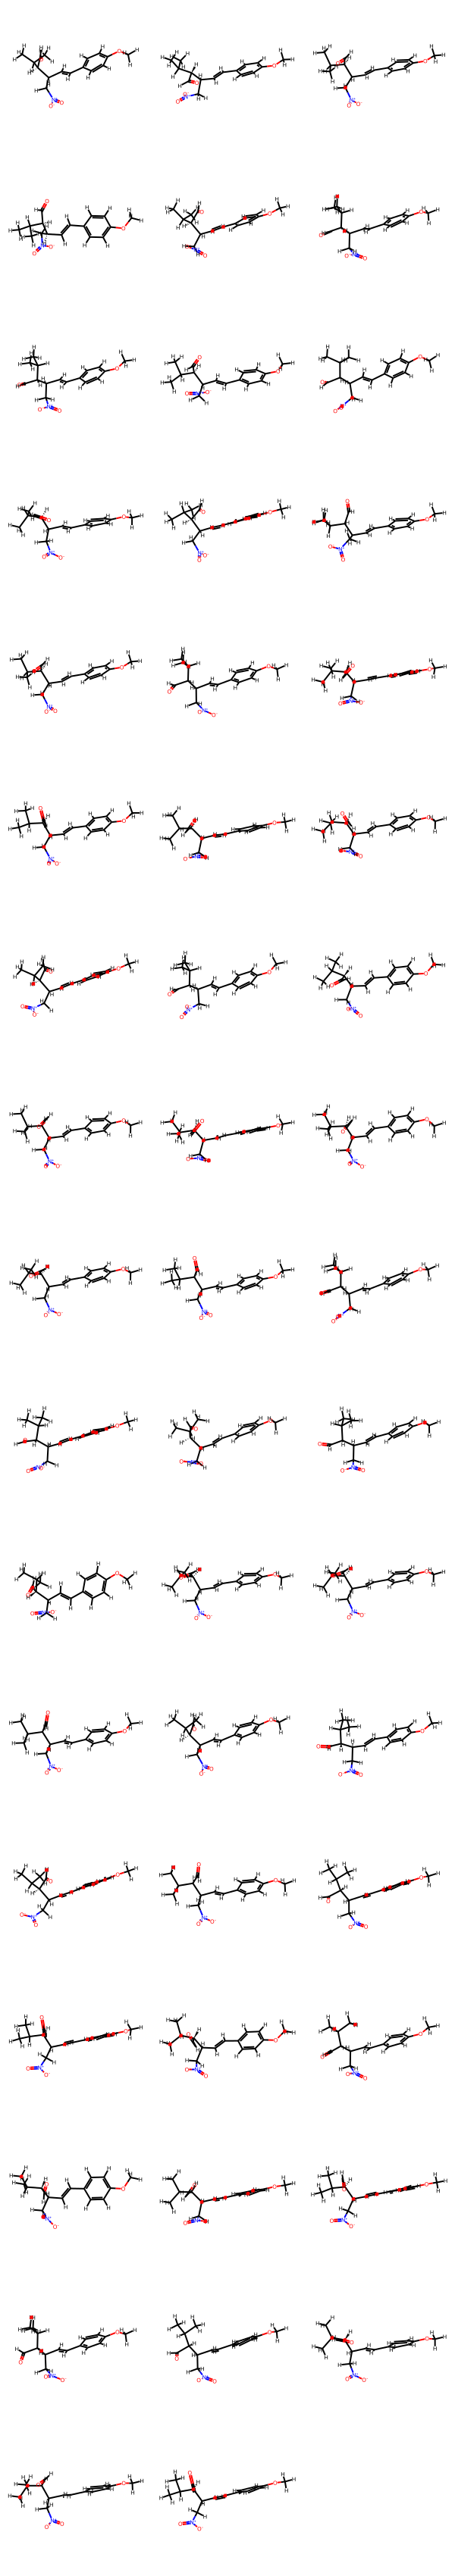

In [21]:
Chem.Draw.MolsToGridImage(
    [Chem.Mol(result_mol, confId=i + 1) for i in range(result_mol.GetNumConformers())]
)

In [22]:
conformers = [i for i in result_mol.GetConformers()]

In [23]:
conf = conformers[0]

In [24]:
conf.GetId()

0

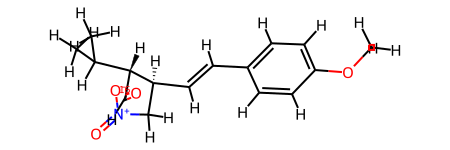

In [25]:
Chem.Mol(test_mol, confId=2)

In [26]:
sim_mol = Molecule.from_rdkit(Chem.Mol(test_mol, confId=2))

In [27]:
sim_mol.conformers

[<Quantity([[-4.57160881e+00  8.68451223e-01  1.18122649e+00]
  [-3.84343873e+00  3.50117492e-01 -6.69262980e-02]
  [-3.98308193e+00  1.36886824e+00 -1.17509119e+00]
  [-2.44261024e+00  5.11108154e-03  3.14411212e-01]
  [-2.62878702e+00 -1.05300174e+00  1.41016893e+00]
  [-2.20546504e+00 -8.84910013e-01  2.52065052e+00]
  [-1.52092705e+00 -4.83056499e-01 -6.97426949e-01]
  [-1.72485363e+00 -1.73837887e+00 -1.46786541e+00]
  [-2.90540321e+00 -1.71924826e+00 -2.25168632e+00]
  [-3.79837577e+00 -2.50773205e+00 -2.08874766e+00]
  [-3.02556701e+00 -7.75873364e-01 -3.25996960e+00]
  [-9.92057348e-02 -6.44329549e-01 -1.50905755e-01]
  [ 8.47541508e-01  2.02498496e-01 -4.42104395e-01]
  [ 2.21726155e+00  1.34780052e-01  2.43054713e-02]
  [ 3.16869360e+00  1.09525484e+00 -3.43435841e-01]
  [ 4.46911476e+00  1.04465725e+00  9.00049082e-02]
  [ 4.90548073e+00  3.26052223e-02  9.18629411e-01]
  [ 3.98668469e+00 -9.24788648e-01  1.29426067e+00]
  [ 2.67998314e+00 -8.65810506e-01  8.53166301e-01]
  

In [28]:
parent = Chem.MolFromSmiles("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O")

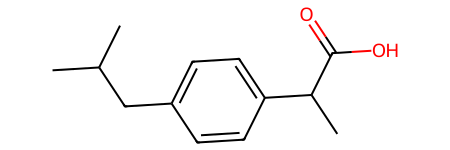

In [29]:
parent

In [30]:
Chem.rdmolops.NeedsHs(parent)

True

In [31]:
parent = Chem.rdmolops.AddHs(parent)

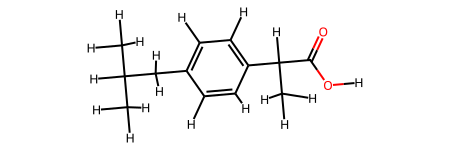

In [32]:
parent

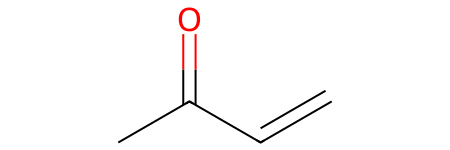

In [33]:
Chem.MolFromSmiles("CC(=O)C=C")

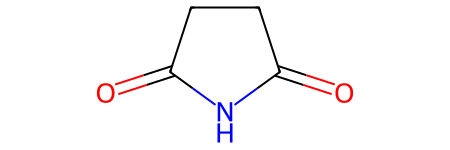

In [34]:
Chem.MolFromSmiles("O=C1NC(=O)CC1")

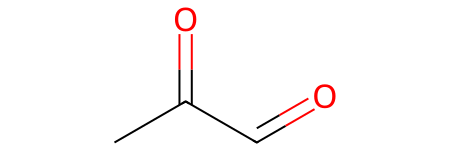

In [35]:
Chem.MolFromSmiles("CC(=O)C=O")

In [36]:
from gypsum_dl import GypsumDL

In [37]:
GypsumDL.run_gypsum_dl()

TypeError: GypsumDL.run_gypsum_dl() missing 1 required positional argument: 'self'

In [ ]:
default = OrderedDict(
    {
        "source": "",
        "output_folder": "./",
        "separate_output_files": False,
        "add_pdb_output": False,
        "add_html_output": False,
        "num_processors": -1,
        "start_time": 0,
        "end_time": 0,
        "run_time": 0,
        "min_ph": 6.4,
        "max_ph": 8.4,
        "pka_precision": 1.0,
        "thoroughness": 3,
        "max_variants_per_compound": 5,
        "second_embed": False,
        "2d_output_only": False,
        "skip_optimize_geometry": False,
        "skip_alternate_ring_conformations": False,
        "skip_adding_hydrogen": False,
        "skip_making_tautomers": False,
        "skip_enumerate_chiral_mol": False,
        "skip_enumerate_double_bonds": False,
        "let_tautomers_change_chirality": False,
        "use_durrant_lab_filters": False,
        "job_manager": "multiprocessing",
        "cache_prerun": False,
        "test": False,
    }
)